## Large objects with protrusions and "self prediction"


In this example we test cellpose on the image provided in this [thread](https://forum.image.sc/t/cellpose-segmentation-training-cyto2-with-own-images-not-precise-enough/110808) 

The template notebook, from which this one is derived was inspired by this Image.sc [question](https://forum.image.sc/t/challenging-segmentation-with-cellpose-need-help/103618) we try to finetune Cellpose to segment large objects with long protrusions.  Images kindly shared by Arkajyoti Sakar

"Self Prediction", when you train and test a model on the same (often low N) collection of images is a bad way to evaluate a model, but sometimes a very good way to trouble shoot a model.  "Self-prediction" with low N and a lot of training should result in an almost perfect prediction (as the model will memorize structure), if you are not getting almost perfect prediction the training and/or prediction settings may be sub-optimal.  In this example we use the self-prediction of a single image to trouble shoot whether the Cellpose settings are configured for optimal protrusion segmentation. 

Note:  After optimizing settings we still don't know if such a model can generalize, for this we need to train on many images and then test on 'un-seen' (by the trainer) images.  T

num inputs:  1
num ground truth:  1
image label paths [WindowsPath('D:/images/tnia-python-images/imagesc/2025_04_07_cellpose_not_precise_dense/labels/input0')]
ground_truth_label_paths D:\images\tnia-python-images\imagesc\2025_04_07_cellpose_not_precise_dense\labels\ground truth0


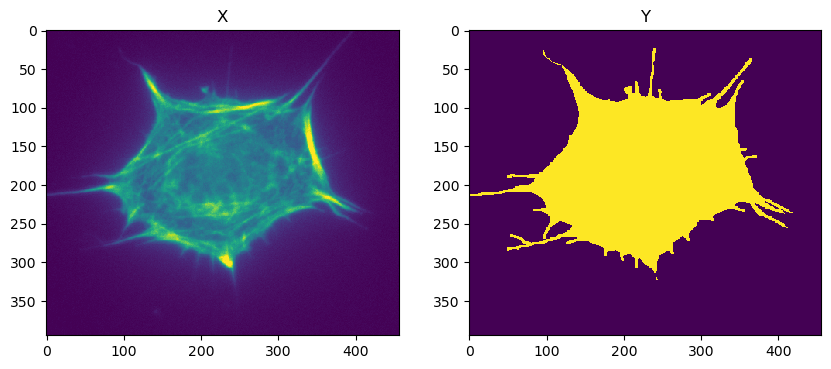

In [3]:
from skimage.io import imread
from tnia.deeplearning.dl_helper import quantile_normalization, get_label_paths
from tnia.plotting.plt_helper import imshow_multi2d
import json
import os
from skimage.measure import label
from cellpose import models, io

parent_path = os.path.join(r"D:\images\tnia-python-images\imagesc\2025_04_07_cellpose_not_precise_dense")
label_path = os.path.join(parent_path, 'labels')

im_name = 'Screenshot from 2025-03-31 10-28-06'

# open the info file
json_name = os.path.join(label_path, 'info.json')
json_ = json.load(open(json_name))

# get number of inputs and number of ground truths for this problem
num_inputs = json_['num_inputs']
num_ground_truths = json_['num_truths']
print('num inputs: ', num_inputs)   
print('num ground truth: ', num_ground_truths)

image_label_paths, ground_truths_label_paths = get_label_paths(1, num_ground_truths, label_path)
print('image label paths',image_label_paths)
print("ground_truth_label_paths", ground_truths_label_paths[0])

X = imread(os.path.join(image_label_paths[0], im_name+'_0.tif'))
Y = imread(os.path.join(ground_truths_label_paths[0], im_name+'_0.tif'))

X = quantile_normalization(X, channels=True)
Y = label(Y)

fig = imshow_multi2d([X, Y], ['X', 'Y'], 1, 2)



pretrained_model path does not exist, using default model
pretrained_model path does not exist, using default model
pretrained_model path does not exist, using default model


2025-04-09 06:09:48,541 [INFO] WRITING LOG OUTPUT TO C:\Users\bnort\.cellpose\run.log
2025-04-09 06:09:48,542 [INFO] 
cellpose version: 	3.1.0 
platform:       	win32 
python version: 	3.11.11 
torch version:  	2.6.0


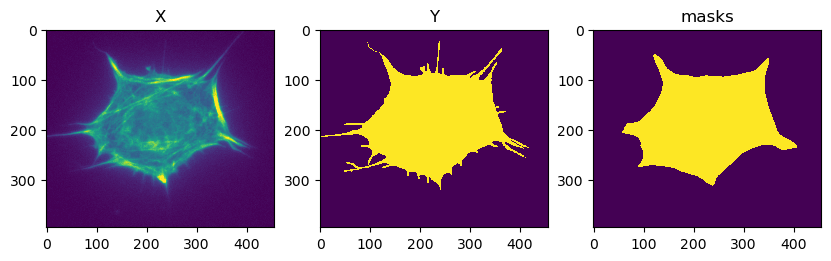

In [4]:
model_cyto3 = models.CellposeModel(gpu=True, model_type="cyto3")

new_models = False

if new_models:
    model_finetuned_defaults = models.CellposeModel(gpu=True, model_type="cyto3")
    model_finetuned_no_rescale = models.CellposeModel(gpu=True, model_type="cyto3")
    model_finetuned_no_rescale_bsize_512 = models.CellposeModel(gpu=True, model_type="cyto3")
else:
    model_finetuned_defaults = models.CellposeModel(gpu=True, pretrained_model=os.path.join(parent_path, 'models', 'defaults'))   
    model_finetuned_no_rescale = models.CellposeModel(gpu=True, pretrained_model=os.path.join(parent_path, 'models', 'no_rescale'))
    model_finetuned_no_rescale_bsize_512 = models.CellposeModel(gpu=True, pretrained_model=os.path.join(parent_path, 'models', 'no_rescale_bsize_512'))
logger = io.logger_setup()

masks = model_cyto3.eval(X, diameter=100, channels=[2,3])
fig = imshow_multi2d([X, Y, masks[0]], ['X', 'Y', 'masks'], 1, 3)


## Replicate training image to minimize 'randomness' in training

Here we copy the training data 100 times.  Cellpose training has a built in augmentation step (which I don't think we can turn off through the API.. correct me if I missed this option).  Thus if we only have 1 training image, each epoch will consist of 1 augmented image, and the model at the end of an epoch can be randomly different depending on the augmentation... however if we present 100 of the same images, an epoch will consist of 100 random augmentations, thus minimizing the randomness.  

In [5]:
X_list = [X]*100
Y_list = [Y]*100

print(len(X_list))

100


In [6]:
from cellpose import train

train.train_seg( model_finetuned_no_rescale.net, X_list, Y_list,   
                channels=[2,3], 
                save_path=parent_path, 
                n_epochs=500,
                min_train_masks=0,
                rescale = False,  
                model_name='no_rescale',
                normalize=False)

2025-04-09 06:10:16,893 [INFO] computing flows for labels


100%|██████████| 100/100 [00:29<00:00,  3.36it/s]

2025-04-09 06:10:46,726 [INFO] >>> computing diameters



100%|██████████| 100/100 [00:00<00:00, 1610.95it/s]

2025-04-09 06:10:46,793 [INFO] >>> using channels [2, 3]
2025-04-09 06:10:46,858 [INFO] >>> n_epochs=500, n_train=100, n_test=None
2025-04-09 06:10:46,859 [INFO] >>> AdamW, learning_rate=0.00500, weight_decay=0.00001


2025-04-09 06:10:48,676 [INFO] >>> saving model to D:\images\tnia-python-images\imagesc\2025_04_07_cellpose_not_precise_dense\models\no_rescale
2025-04-09 06:10:50,738 [INFO] 0, train_loss=3.8748, test_loss=0.0000, LR=0.000000, time 2.06s
2025-04-09 06:10:59,246 [INFO] 5, train_loss=2.5813, test_loss=0.0000, LR=0.002778, time 10.57s
2025-04-09 06:11:07,400 [INFO] 10, train_loss=0.6046, test_loss=0.0000, LR=0.005000, time 18.72s
2025-04-09 06:11:23,542 [INFO] 20, train_loss=0.3241, test_loss=0.0000, LR=0.005000, time 34.87s
2025-04-09 06:11:39,246 [INFO] 30, train_loss=0.2548, test_loss=0.0000, LR=0.005000, time 50.57s
2025-04-09 06:11:55,179 [INFO] 40, train_loss=0.2375, test_loss=0.0000, LR=0.005000, time 66.50s
2025-04-09 06:12:11,093 [INFO] 50, train_loss=0.1812, test_loss=0.0000, LR=0.005000, time 82.42s
2025-04-09 06:12:27,173 [INFO] 60, train_loss=0.1755, test_loss=0.0000, LR=0.005000, time 98.50s
2025-04-09 06:12:43,236 [INFO] 70, train_loss=0.1527, test_loss=0.0000, LR=0.005000

(WindowsPath('D:/images/tnia-python-images/imagesc/2025_04_07_cellpose_not_precise_dense/models/no_rescale'),
 array([3.87482458, 3.69772701, 3.08309114, 2.67765025, 1.89376712,
        1.55449291, 1.01219499, 0.69434469, 0.53565799, 0.43238642,
        0.34835959, 0.38478601, 0.34098689, 0.27946328, 0.43641367,
        0.3225186 , 0.30298262, 0.38973258, 0.25117669, 0.27969124,
        0.25349159, 0.28471103, 0.25155863, 0.2944228 , 0.22095883,
        0.23824252, 0.3084526 , 0.24391485, 0.24827893, 0.21860497,
        0.23897274, 0.25377736, 0.20765787, 0.26573255, 0.25138672,
        0.27586749, 0.22850965, 0.21179432, 0.23656204, 0.21865173,
        0.22486294, 0.15520089, 0.19164313, 0.19410271, 0.19646746,
        0.20683186, 0.16382914, 0.18938311, 0.17390989, 0.17505957,
        0.16524497, 0.20475676, 0.18074843, 0.17247792, 0.17279171,
        0.16933038, 0.1663025 , 0.17178882, 0.16329037, 0.20538639,
        0.14820078, 0.14557643, 0.15915315, 0.17909746, 0.1443129 ,
      

In [7]:
train.train_seg( model_finetuned_no_rescale_bsize_512.net, X_list, Y_list,   
                channels=[2,3], 
                save_path=parent_path, 
                n_epochs=500,
                min_train_masks=0,
                rescale = False,  
                model_name='no_rescale_bsize_512',
                normalize=False,
                bsize=512)

2025-04-09 06:23:52,956 [INFO] computing flows for labels


100%|██████████| 100/100 [00:31<00:00,  3.22it/s]

2025-04-09 06:24:24,056 [INFO] >>> computing diameters



100%|██████████| 100/100 [00:00<00:00, 1666.62it/s]

2025-04-09 06:24:24,121 [INFO] >>> using channels [2, 3]
2025-04-09 06:24:24,189 [INFO] >>> n_epochs=500, n_train=100, n_test=None
2025-04-09 06:24:24,190 [INFO] >>> AdamW, learning_rate=0.00500, weight_decay=0.00001
2025-04-09 06:24:24,192 [INFO] >>> saving model to D:\images\tnia-python-images\imagesc\2025_04_07_cellpose_not_precise_dense\models\no_rescale_bsize_512


2025-04-09 06:24:30,686 [INFO] 0, train_loss=1.6056, test_loss=0.0000, LR=0.000000, time 6.49s
2025-04-09 06:25:03,024 [INFO] 5, train_loss=0.8071, test_loss=0.0000, LR=0.002778, time 38.83s
2025-04-09 06:25:35,901 [INFO] 10, train_loss=0.1132, test_loss=0.0000, LR=0.005000, time 71.71s
2025-04-09 06:26:41,362 [INFO] 20, train_loss=0.0666, test_loss=0.0000, LR=0.005000, time 137.17s
2025-04-09 06:27:47,429 [INFO] 30, train_loss=0.0550, test_loss=0.0000, LR=0.005000, time 203.24s
2025-04-09 06:28:52,981 [INFO] 40, train_loss=0.0475, test_loss=0.0000, LR=0.005000, time 268.79s
2025-04-09 06:29:59,324 [INFO] 50, train_loss=0.0427, test_loss=0.0000, LR=0.005000, time 335.13s
2025-04-09 06:31:04,472 [INFO] 60, train_loss=0.0403, test_loss=0.0000, LR=0.005000, time 400.28s
2025-04-09 06:32:09,892 [INFO] 70, train_loss=0.0378, test_loss=0.0000, LR=0.005000, time 465.70s
2025-04-09 06:33:14,967 [INFO] 80, train_loss=0.0354, test_loss=0.0000, LR=0.005000, time 530.78s
2025-04-09 06:34:20,031 [I

(WindowsPath('D:/images/tnia-python-images/imagesc/2025_04_07_cellpose_not_precise_dense/models/no_rescale_bsize_512'),
 array([1.60563358, 1.36274577, 1.03025012, 0.84127769, 0.51967283,
        0.28168746, 0.17603717, 0.11792932, 0.09773261, 0.09108233,
        0.0832975 , 0.07728599, 0.07234862, 0.06444931, 0.07758949,
        0.0724823 , 0.05933653, 0.06561291, 0.05626451, 0.05897286,
        0.06173933, 0.06001495, 0.05744811, 0.06164635, 0.05461709,
        0.05301905, 0.05745121, 0.05500287, 0.04917102, 0.05429746,
        0.04769673, 0.04674347, 0.04602671, 0.05106584, 0.05058265,
        0.05115863, 0.0454214 , 0.04529987, 0.04901952, 0.04358521,
        0.04639356, 0.04216684, 0.04567032, 0.04547294, 0.04482447,
        0.04203373, 0.04133206, 0.04432009, 0.04074585, 0.04219119,
        0.03814782, 0.04180343, 0.04463781, 0.04286849, 0.04483143,
        0.03817661, 0.03925438, 0.03933562, 0.03672836, 0.03804694,
        0.03723831, 0.04047274, 0.0403774 , 0.03755354, 0.034913

In [8]:
train.train_seg( model_finetuned_defaults.net, X_list, Y_list,   
                channels=[2,3], 
                save_path=parent_path, 
                n_epochs=500,
                min_train_masks=0,
                model_name='defaults',
                normalize=False)

2025-04-09 07:54:04,820 [INFO] computing flows for labels


100%|██████████| 100/100 [00:31<00:00,  3.16it/s]

2025-04-09 07:54:36,507 [INFO] >>> computing diameters



100%|██████████| 100/100 [00:00<00:00, 1470.59it/s]

2025-04-09 07:54:36,579 [INFO] >>> using channels [2, 3]
2025-04-09 07:54:36,643 [INFO] >>> n_epochs=500, n_train=100, n_test=None
2025-04-09 07:54:36,645 [INFO] >>> AdamW, learning_rate=0.00500, weight_decay=0.00001
2025-04-09 07:54:36,647 [INFO] >>> saving model to D:\images\tnia-python-images\imagesc\2025_04_07_cellpose_not_precise_dense\models\defaults


2025-04-09 07:54:38,123 [INFO] 0, train_loss=0.1171, test_loss=0.0000, LR=0.000000, time 1.48s
2025-04-09 07:54:45,344 [INFO] 5, train_loss=0.0477, test_loss=0.0000, LR=0.002778, time 8.70s
2025-04-09 07:54:52,530 [INFO] 10, train_loss=0.0157, test_loss=0.0000, LR=0.005000, time 15.88s
2025-04-09 07:55:06,986 [INFO] 20, train_loss=0.0117, test_loss=0.0000, LR=0.005000, time 30.34s
2025-04-09 07:55:21,620 [INFO] 30, train_loss=0.0098, test_loss=0.0000, LR=0.005000, time 44.97s
2025-04-09 07:55:36,123 [INFO] 40, train_loss=0.0085, test_loss=0.0000, LR=0.005000, time 59.48s
2025-04-09 07:55:50,647 [INFO] 50, train_loss=0.0076, test_loss=0.0000, LR=0.005000, time 74.00s
2025-04-09 07:56:05,422 [INFO] 60, train_loss=0.0070, test_loss=0.0000, LR=0.005000, time 88.77s
2025-04-09 07:56:20,035 [INFO] 70, train_loss=0.0067, test_loss=0.0000, LR=0.005000, time 103.39s
2025-04-09 07:56:34,851 [INFO] 80, train_loss=0.0063, test_loss=0.0000, LR=0.005000, time 118.20s
2025-04-09 07:56:49,471 [INFO] 9

(WindowsPath('D:/images/tnia-python-images/imagesc/2025_04_07_cellpose_not_precise_dense/models/defaults'),
 array([0.11708385, 0.09053319, 0.05809735, 0.0396458 , 0.02861908,
        0.02182015, 0.01831466, 0.01638196, 0.0153052 , 0.01475351,
        0.01390623, 0.01319558, 0.012696  , 0.01198378, 0.01238966,
        0.01212983, 0.01126219, 0.01149049, 0.01074238, 0.01070402,
        0.0107317 , 0.01053187, 0.01026994, 0.01059572, 0.00990889,
        0.00984047, 0.01007911, 0.00959709, 0.00914807, 0.00939551,
        0.00889265, 0.00878344, 0.00854156, 0.00890096, 0.008842  ,
        0.00873571, 0.00828545, 0.00823437, 0.00853601, 0.00793531,
        0.0080793 , 0.00774009, 0.00798672, 0.00794239, 0.00782781,
        0.00757321, 0.00737071, 0.00767636, 0.0072455 , 0.00738534,
        0.00722098, 0.00724959, 0.00740982, 0.00722323, 0.00746292,
        0.00694177, 0.00685085, 0.00698512, 0.00672564, 0.00684936,
        0.00672103, 0.00687021, 0.00685487, 0.00676451, 0.00653737,
        

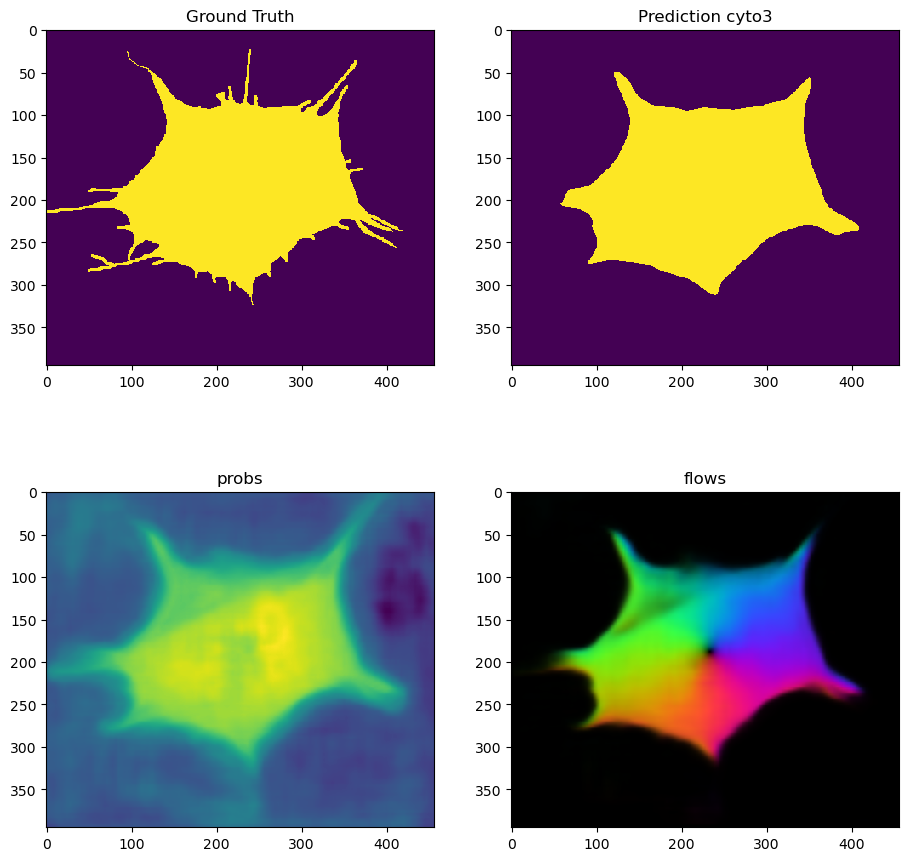

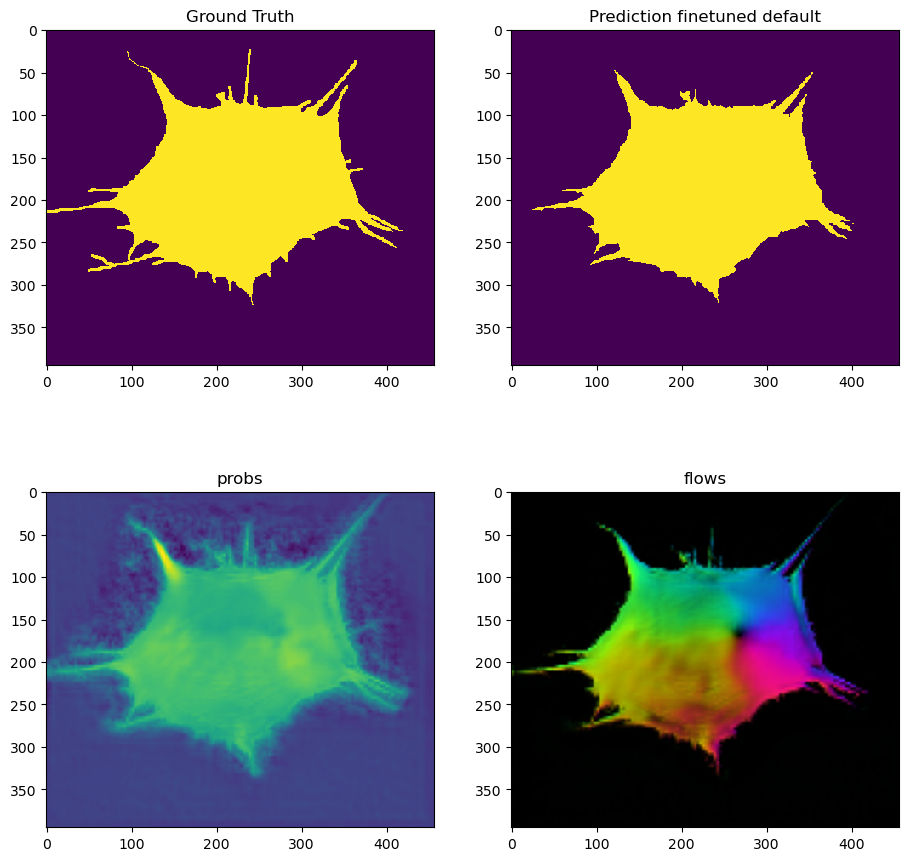

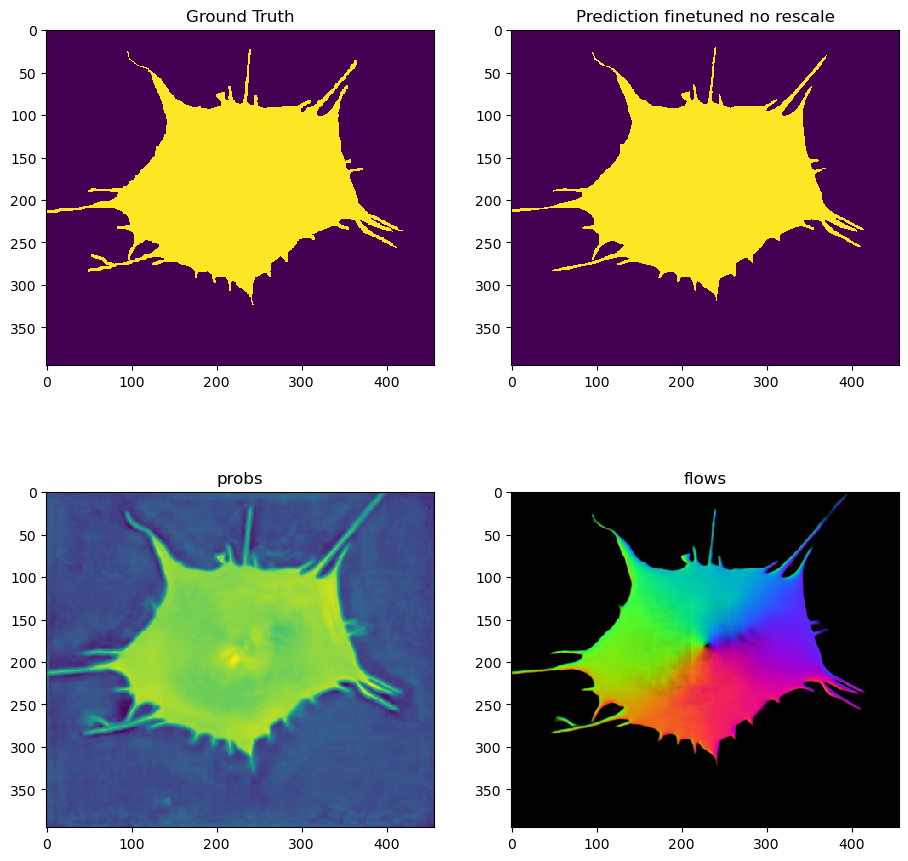

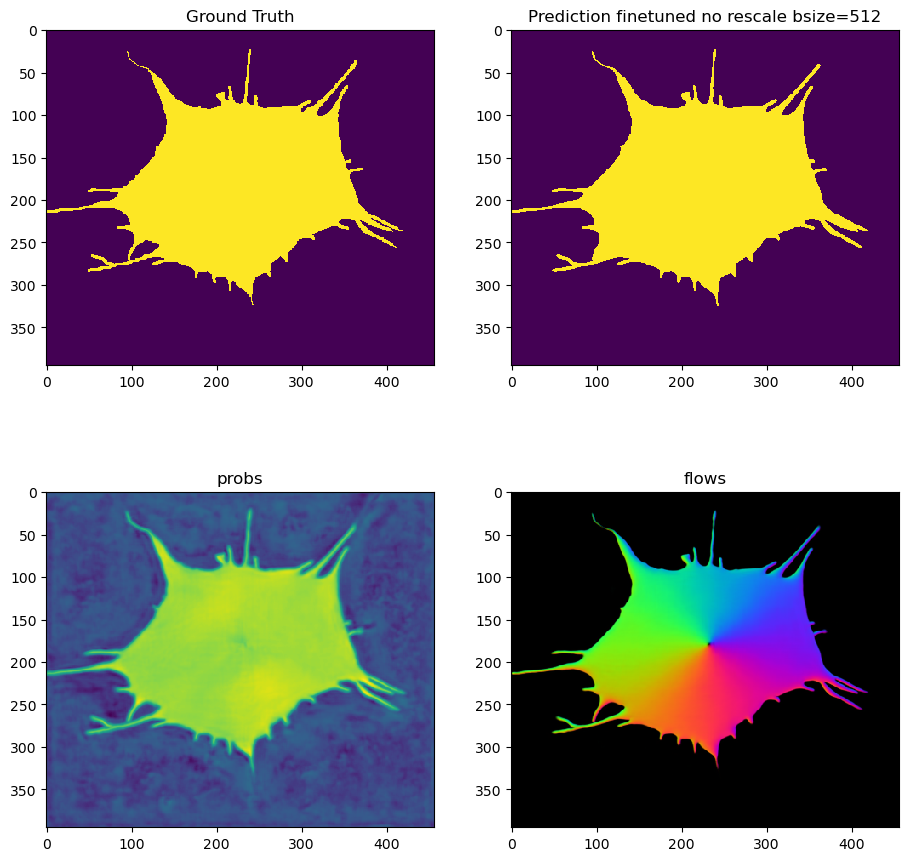

In [9]:

masks = model_cyto3.eval(X, diameter=100, niter=2000, channels=[2,3])
fog = imshow_multi2d([Y, masks[0], masks[1][2], masks[1][0]], ['Ground Truth', 'Prediction cyto3', 'probs', 'flows'], 2, 2, width=11, height=11)

masks_defaults = model_finetuned_defaults.eval(X, diameter=100, niter=2000, channels=[2,3], normalize=False)
fig = imshow_multi2d([Y, masks_defaults[0], masks_defaults[1][2], masks_defaults[1][0]], ['Ground Truth', 'Prediction finetuned default', 'probs', 'flows'], 2, 2, width=11, height=11)

masks_no_rescale = model_finetuned_no_rescale.eval(X, diameter=30, niter=2000, channels=[2,3], normalize=False)
fig = imshow_multi2d([Y, masks_no_rescale[0], masks_no_rescale[1][2], masks_no_rescale[1][0]], ['Ground Truth', 'Prediction finetuned no rescale', 'probs', 'flows'], 2, 2, width=11, height=11) 

masks_no_rescale_bsize_512 = model_finetuned_no_rescale_bsize_512.eval(X, diameter=30, niter=2000, bsize=512, channels=[2,3], cellprob_threshold=-1.0, normalize=False)
fig = imshow_multi2d([Y, masks_no_rescale_bsize_512[0], masks_no_rescale_bsize_512[1][2], masks_no_rescale_bsize_512[1][0]], ['Ground Truth', 'Prediction finetuned no rescale bsize=512', 'probs', 'flows'], 2, 2, width=11, height=11)


In [56]:
import napari

viewer = napari.Viewer()

viewer.add_image(masks_no_rescale_bsize_512[0], name='prediction')
viewer.add_image(masks_no_rescale_bsize_512[1][0], name='flow')
viewer.add_image(masks_no_rescale_bsize_512[1][2], name='prob')

<Image layer 'prob' at 0x11bfdeb8220>